In [1]:
import pickle 
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.optimize import minimize
from IPython.display import display, Latex


In [2]:
d2metals = {
    '3': ['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni'],
    '4': ['Nb', 'Mo', ],
    '5': ['W', ]
}

# for plotting
ele2col = {
    "Ti": "#808080",
    "V": "#ffcccb",
    "Cr": "k",
    "Mn": "#9b870c",
    "Fe": "r",
    "Co": "b",
    "Cu": "#FFFF00",
    "Nb": "cyan",
    "Mo": "#FFA500",
    "Sn": "k",
    "W": "fuchsia",
    "Ir": "b",
    "Ni": "#66FF00",
}

In [47]:
def plot_parabola(parabola):
    x = np.linspace(0, 4, 10)
    y = parabola[0]*x**2+parabola[1]*x
    plt.plot(x, y)
    
def formation_energy_mixing(ele1, ele2, concentrations, plotting=False):
    ox_quadratic_1 = mp_quadratic_equations_ox[ele1]
    ox_quadratic_2 = mp_quadratic_equations_ox[ele2]
    red_quadratic_1 = mp_quadratic_equations_red[ele2]
    red_quadratic_2 = mp_quadratic_equations_red[ele1]

    predicted_forms_1 = []
    predicted_forms_2 = []
    predicted_ox_change_1 = []
    predicted_ox_change_2 = []
    for conc in concentrations:
        
        o_1a, o_2a, o_3a = ox_quadratic_1
        r_1a, r_2a, r_3a = red_quadratic_1

        o_1b, o_2b, o_3b = ox_quadratic_2
        r_1b, r_2b, r_3b = red_quadratic_2
        if plotting:
            #print('checking {}'.format(conc))
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, r_1a, r_2a, True), bounds=[(0, 10)])
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, r_1b, r_2b, True), bounds=[(0, 10)])
            
        else:
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, r_1a, r_2a),  bounds=[(0, 10)])
            # Note, the definition of concentration is different  between 1/2,
            # since it relates to the concentration of the element that is 
            # oxidisint or reducing.
            #handle this when plotting by flipping the x-axis horizontally
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, r_1b, r_2b),  bounds=[(0, 10)])
        
        x_space = np.linspace(0, 3, 50)
        predicted_ox_change_1.append(result_1.x[0])
        # this can give problems depending on scipy version, might have to use result_1.fun
        predicted_forms_1.append(result_1.fun)
        predicted_ox_change_2.append(result_2.x[0])
        predicted_forms_2.append(result_2.fun)#result_2.fun[0] + diff*(1-conc))
        
#         mixed_1 = o_1a*(x_space**2)*(1-conc)**2+o_2a*x_space*(1-conc)+r_1a*(x_space**2)*conc**2+r_2a*x_space*conc
#         ox1 = o_1a*x_space**2+o_2a*x_space
#         red1 = r_1a*x_space**2+r_2a*x_space
        
#         mixed_2 = o_1b*(x_space**2)*(conc)**2+o_2b*x_space*(conc)+(r_1b*((1-conc)*x_space)**2+r_2b*(1-conc)*x_space)
#         ox2 = o_1b*x_space**2+o_2b*x_space
#         red2 = r_1b*x_space**2+r_2b*x_space
#         if conc==0 or conc==1:
#             continue

    xs_1 = []
    xs_2 = []
    for conc in concentrations:
        # need to shift the energies so that either end is set to 0
        # so shift every point proportionally
        xs_1.append(predicted_forms_1[0]*(1-conc)+predicted_forms_1[-1]*(conc))
        xs_2.append(predicted_forms_2[0]*(1-conc)+predicted_forms_2[-1]*(conc))
        
    return np.array(predicted_forms_1)-xs_1, np.array(predicted_forms_2)-xs_2, predicted_ox_change_1, predicted_ox_change_2

def oxidation_reduction_equation(x, ox_conc, o1, o2, r1, r2, plot=False):
    """
    Defines the equation to optimize oxidation state when mixed
    Args:
    x: The amount of oxidation state change
    ox_conc: The concentration of the oxidising element between 0 and 1
    o1, o2, o3: Define the quadratic equation for the oxidising element
    r1, r2, r3: Define the quadratic equation for the reducing element
    """
    return (o1*x**2*(1-ox_conc)**2+o2*x*(1-ox_conc))+(r1*(ox_conc*x)**2+r2*(ox_conc*x))


def find_nearest(array, value):
    """
    Helper function to find the closest conc
    """
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx


In [48]:
mp_quadratic_equations_ox = pickle.load(open('make_quadratics/mp_quadratic_equations_ox.p', 'rb'))
mp_quadratic_equations_red = pickle.load(open('make_quadratics/mp_quadratic_equations_red.p', 'rb'))

binary_pairing_data = pickle.load(open('data_gather/binary_pairing_data.p', 'rb'))

# iterate over these eqs, removing the oxidation number label to get all the elements 
set_of_elements = set([x[:-1] for x in mp_quadratic_equations_ox])

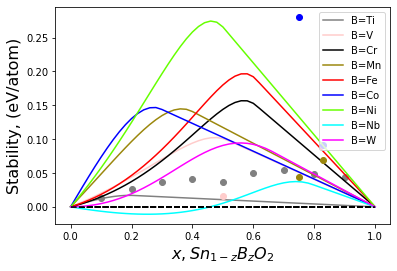

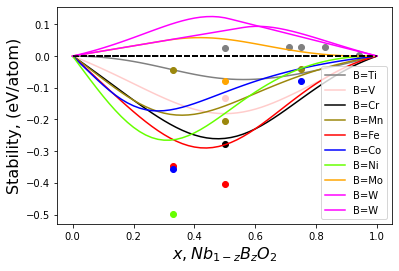

In [49]:
oxidation_state = 4
for housing_element in ['Sn', 'Nb']:
    house_ele_ox = housing_element+str(oxidation_state)
    #print(house_ele_ox)
    if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
        print("Missing eq for {}".format(housing_element))
        continue
    
    pairings = []
    ground_states =  []
    zs = np.linspace(0, 1.00, 51)

    for ele in d2metals['3']+d2metals['4']+d2metals['5']:
        #print(ele)
        dope_ele_ox = ele+str(oxidation_state)
        if ele==housing_element:
            continue

        else: 
            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )

        can_reduce = True
        can_oxidise = True
        # check if it found any solutions 
        if sum(ox_1)==0:
            can_reduce = False
        if sum(ox_2)==0:
            can_oxidise = False 
            
        if can_reduce:
            plt.plot(zs, pred_1, label="B={}".format(ele), color=ele2col[ele])
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        if can_oxidise:
            plt.plot(zs, pred_2, label="B={}".format(ele), ls='-', color=ele2col[ele])#, 'r-')
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        
        if ele<housing_element:
            info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(4)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
        else:
            info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(4)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])

        
    plt.legend()
    plt.xlabel("$x, {}_{{1-z}}B_{{z}}O_{{2}}$".format(housing_element, ), fontsize=16)
    plt.ylabel("Stability, (eV/atom)", fontsize=16)
    #plt.ylim(-0.1, 0.1)
    plt.savefig("{}_higherdmixing.pdf".format(housing_element))
    plt.show()
        
        

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 790
MAE for unfiltered: 0.238
total matches with good geom: 237
MAE for filtered: 0.131


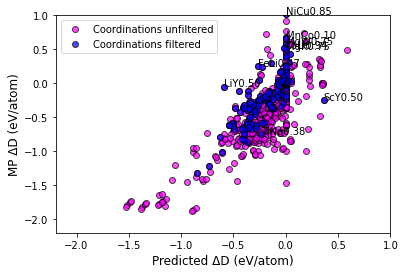

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 1433
MAE for unfiltered: 0.267
total matches with good geom: 183
MAE for filtered: 0.131


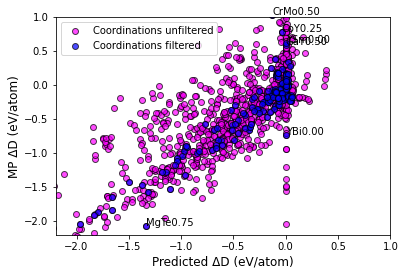

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 945
MAE for unfiltered: 0.139
total matches with good geom: 301
MAE for filtered: 0.112


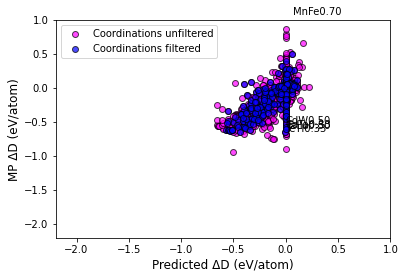

In [50]:
ox2oxide_type = {
    "2": "$A_{1-z}B_{z}O$",
    "3": "$A_{1-z}B_{z}O_{1.5}$",
    "4": "$A_{1-z}B_{z}O_{2}$"
}
for oxidation_state in [2, 3, 4]:
    print("Checking oxides of type as below")
    display(Latex(ox2oxide_type[str(oxidation_state)]))
    data_dict = defaultdict()
    seen_combinations = []

    for housing_element in set_of_elements:
        house_ele_ox = housing_element+str(oxidation_state)
        if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
            print("Missing eq for {}".format(housing_element))
            continue

        pairings = []
        ground_states =  []
        zs = np.linspace(0, 1.00, 51)

        for ele in set_of_elements:
            dope_ele_ox = ele+str(oxidation_state)
            if housing_element+ele in seen_combinations or ele+housing_element in seen_combinations or ele==housing_element:
                continue
            else:
                seen_combinations.append(ele+housing_element)
            if ele<housing_element:
                info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(int(oxidation_state))]
            else:
                info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(int(oxidation_state))]
            if len(info_dict)==0:
                continue

            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )
            for ele_conc in info_dict:
                conc = float(ele_conc.split("_")[1])
                closest_idx = find_nearest(zs, conc)
                key = ""

                if ele+"_{:.2f}".format(conc) in info_dict.keys():
                    # the 'element' variable is the one with that conc
                    # the ele conc is the one we get a ΔD value for at 
                    # given conc, and this has to match the way
                    # the weighted average was calculated
                    key = ele+"_{:.2f}".format(conc)
                    # this key will be accessed later
                    inner_key = ele+housing_element+"{:.2f}".format(conc)
                    closest_idx = find_nearest(zs, conc)

                else:
                    # the 'housing_element' is the one with that conc
                    key = housing_element+"_{:.2f}".format(conc)
                    inner_key = housing_element+ele+"{:.2f}".format(conc)
                    # since the ΔD is calculated for ele conc, need to switch 
                    # to the other side of the diagram
                    closest_idx = find_nearest(zs, 1-conc)
                if pred_2[closest_idx]<pred_1[closest_idx]:
                    ox_change = ox_2[closest_idx]
                else:
                    ox_change = ox_1[closest_idx]

                data_dict[inner_key] = {
                    "predicted ΔD": min(pred_2[closest_idx], pred_1[closest_idx]),
                    "true ΔD": info_dict[key]['MP ΔD'],
                    "predicted formation energy": min(pred_2[closest_idx], pred_1[closest_idx]) + info_dict[key]['MP weighted average'],
                    "true formation energy": info_dict[key]['MP weighted average']+info_dict[key]['MP ΔD'],
                    "weighted average of refs": info_dict[key]['MP weighted average'],
                    "coordination_match": info_dict[key]['Coordination match'],
                    "x_tot": ox_change,
                    "mp_id": info_dict[key]['MP_id'],
                    "mp_name": info_dict[key]['MP_name'],
                    "motifs": info_dict[key]['motifs'],
                }
    xs = []
    ys = []
    for key, val in data_dict.items():
        xs.append(val['predicted ΔD'])
        ys.append(val['true ΔD'])

    print("total matches: {}".format(len(xs)))
    plt.plot(xs, ys, 'o', color='fuchsia', alpha=0.7, label='Coordinations unfiltered', markeredgecolor='k')
    print("MAE for unfiltered: {:.3f}".format(np.mean(abs(np.array(xs)-np.array(ys)))))
    plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
    plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
    #plt.show()
    xs = []
    ys = []
    for key, val in data_dict.items():
        if not val['coordination_match']:
            # bad geometry
            continue
        xs.append(val['predicted ΔD'])
        ys.append(val['true ΔD'])
        if abs(xs[-1]-ys[-1])>0.5:
            plt.text(xs[-1], ys[-1], "{}".format(key))

    print("total matches with good geom: {}".format(len(xs)))
    plt.plot(xs, ys, 'o', color='b', alpha=0.7, label='Coordinations filtered', markeredgecolor='k')
    print("MAE for filtered: {:.3f}".format(np.mean(abs(np.array(xs)-np.array(ys)))))
    plt.legend()
    plt.xlim(-2.2, 1.)
    plt.ylim(-2.2, 1.)
    plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
    plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
    #plt.savefig("parities_ox_state_{}.pdf".format(oxidation_state))
    plt.show()


In [52]:
# calculate total mean absolute error
total = 301+183+237
# 0.112+0.131+0.131
overall_mae = (301*0.112+183*0.131+237*0.131)*(1.0/total)
print("Total MAE: {:.3f} eV/atom".format(overall_mae))

Total MAE: 0.123 eV/atom


### Printing for spreadsheet

In [53]:
ox2oxide_type = {
    "2": "$A_{1-z}B_{z}O$",
    "3": "$A_{1-z}B_{z}O_{1.5}$",
    "4": "$A_{1-z}B_{z}O_{2}$"
}
for oxidation_state in [2, 3, 4]:
    print("Checking oxides of type as below")
    display(Latex(ox2oxide_type[str(oxidation_state)]))
    data_dict = defaultdict()
    seen_combinations = []

    for housing_element in set_of_elements:
        house_ele_ox = housing_element+str(oxidation_state)
        if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
            print("Missing eq for {}".format(housing_element))
            continue

        pairings = []
        ground_states =  []
        zs = np.linspace(0, 1.00, 51)

        for ele in set_of_elements:
            dope_ele_ox = ele+str(oxidation_state)
            if housing_element+ele in seen_combinations or ele+housing_element in seen_combinations or ele==housing_element:
                continue
            else:
                seen_combinations.append(ele+housing_element)
            if ele<housing_element:
                info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(int(oxidation_state))]
            else:
                info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(int(oxidation_state))]
            if len(info_dict)==0:
                continue

            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )
            for ele_conc in info_dict:
                conc = float(ele_conc.split("_")[1])
                closest_idx = find_nearest(zs, conc)
                key = ""

                if ele+"_{:.2f}".format(conc) in info_dict.keys():
                    # the 'element' variable is the one with that conc
                    key = ele+"_{:.2f}".format(conc)
                    # this key will be accessed later
                    inner_key = ele+housing_element+"{:.2f}".format(conc)
                else:
                    # the 'housing_element' is the one with that conc
                    key = housing_element+"_{:.2f}".format(conc)
                    inner_key = housing_element+ele+"{:.2f}".format(conc)

                if pred_2[closest_idx]<pred_1[closest_idx]:
                    ox_change = ox_2[closest_idx]
                else:
                    ox_change = ox_1[closest_idx]

                data_dict[inner_key] = {
                    "predicted ΔD": min(pred_2[closest_idx], pred_1[closest_idx]),
                    "true ΔD": info_dict[key]['MP ΔD'],
                    "predicted formation energy": min(pred_2[closest_idx], pred_1[closest_idx]) + info_dict[key]['MP weighted average'],
                    "true formation energy": info_dict[key]['MP weighted average']+info_dict[key]['MP ΔD'],
                    "weighted average of refs": info_dict[key]['MP weighted average'],
                    "coordination_match": info_dict[key]['Coordination match'],
                    "x_tot": ox_change,
                    "mp_id": info_dict[key]['MP_id'],
                    "mp_name": info_dict[key]['MP_name'],
                    "motifs": info_dict[key]['motifs'],
                }
                print(data_dict[inner_key]['mp_name'], end=", ")
                print(data_dict[inner_key]['mp_id'], end=", ")
                print("{:.4f}".format(data_dict[inner_key]['true formation energy']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['predicted formation energy']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['true ΔD']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['predicted ΔD']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['weighted average of refs']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['x_tot']), end=", ")
                print(data_dict[inner_key]['coordination_match'], end=", ")
                motifs2print = ""
                for motif in data_dict[inner_key]['motifs']:
                    motifs2print+=motif+"/"
                motifs2print = motifs2print[:-1]
                print(motifs2print)




Checking oxides of type as below


<IPython.core.display.Latex object>

Na2SeO3, mp-5416, -1.8040, -1.3398, -0.6633, -0.1992, -1.1407, 2.9471, False, unrecognized
Na4SeO5, mp-29871, -1.6948, -1.3808, -0.4413, -0.1273, -1.2535, 2.5234, False, unrecognized
Hg2SeO3, mp-557637, -0.9263, -0.6168, -0.3095, 0.0000, -0.6168, 0.0000, False, unrecognized
Li4SeO5, mp-4426, -1.9499, -1.8128, -0.4265, -0.2894, -1.5234, 2.7885, False, trigonal bipyramidal/unrecognized
Ag2SeO3, mp-16913, -0.8275, -0.4882, -0.3393, 0.0000, -0.4882, 0.0000, False, unrecognized
KAuO2, mp-997002, -1.1482, -0.8839, -0.3694, -0.1051, -0.7788, 1.1722, False, unrecognized
KScO2, mp-8188, -3.0973, -2.5910, -0.7749, -0.2685, -2.3224, 1.4478, False, unrecognized/octahedral
K3CrO4, mp-19414, -1.9347, -1.7001, -0.3891, -0.1545, -1.5456, 1.3532, False, tetrahedral/unrecognized
KCrO2, mp-546552, -2.1226, -1.8237, -0.4369, -0.1380, -1.6857, 1.2554, False, unrecognized/octahedral
KSnO2, mp-752538, -1.9011, -1.5292, -0.3797, -0.0078, -1.5214, 1.2981, False, unrecognized/octahedral
K2SnO3, mp-17730, -1.962

RbAuO2, mp-7472, -1.1352, -0.8204, -0.3876, -0.0729, -0.7476, 1.1218, False, unrecognized
ScVO2, mp-1209108, -2.5591, -2.4471, 0.1056, 0.2176, -2.6648, 0.0000, False, unrecognized/octahedral
NaScO2, mp-7914, -3.1971, -2.7060, -0.8660, -0.3749, -2.3311, 2.0000, True, octahedral
YbScO2, mp-769119, -3.4106, -2.8029, -0.2437, 0.3640, -3.1669, 0.0000, True, unrecognized/octahedral
YbScO2, mp-769119, -3.4106, -3.4339, 0.0233, 0.0000, -3.4339, 0.0000, True, unrecognized/octahedral
ScTlO2, mp-754384, -2.6858, -1.7876, -0.8481, 0.0501, -1.8377, 1.3132, False, unrecognized/octahedral
ScCuO2, mp-3642, -2.7238, -2.0906, -0.6332, 0.0000, -2.0906, 0.0000, False, unrecognized/octahedral
CsScO2, mp-754826, -2.9788, -2.5583, -0.6888, -0.2684, -2.2900, 1.4663, False, tetrahedral/unrecognized
LiScO2, mp-5840, -3.3436, -3.0142, -0.8438, -0.5144, -2.4998, 2.0000, False, unrecognized/octahedral
ScAgO2, mp-11022, -2.6257, -2.0007, -0.7839, -0.1589, -1.8418, 1.6950, False, unrecognized/octahedral
RbScO2, mp-7

Tl3VO4, mp-29047, -1.6737, -0.7363, -0.8242, 0.1132, -0.8495, 0.0000, False, tetrahedral/unrecognized
MgVO2, mvc-2838, -2.3276, -2.5719, 0.2443, 0.0000, -2.5719, 0.0000, False, unrecognized
DyVO2, mp-1212946, -2.1475, -2.1064, -0.4344, -0.3933, -1.7131, 1.6089, False, unrecognized/octahedral
CeVO2, mp-1213836, -2.4192, -2.4440, 0.2424, 0.2176, -2.6616, 0.0000, False, unrecognized/octahedral
TbVO2, mp-1208383, -2.5215, -2.0940, -0.8128, -0.3853, -1.7087, 1.6064, False, unrecognized/octahedral
VCuO2, mp-997180, -1.8426, -1.5159, -0.3267, 0.0000, -1.5159, 0.0000, False, unrecognized/octahedral
VCu3O4, mp-510657, -1.3155, -1.2288, -0.0867, 0.0000, -1.2288, 0.0000, False, tetrahedral
VPbO2, mp-1208173, -1.4050, -1.7779, 0.3740, 0.0012, -1.7791, 0.0000, False, unrecognized/octahedral
LuVO2, mp-1210719, -2.4111, -2.1608, -0.6789, -0.4286, -1.7322, 1.6198, False, unrecognized/octahedral
LiVO2, mp-19340, -2.4931, -2.2931, -0.5681, -0.3680, -1.9251, 2.0000, True, octahedral
Li3V8O11, mp-1177632,

Na2CdO3, mp-754782, -1.2198, -1.4059, 0.1861, 0.0000, -1.4059, 0.0000, False, octahedral
NaCdO2, mp-754567, -1.3130, -1.3974, 0.0844, 0.0000, -1.3974, 0.0000, True, octahedral
Na5OsO6, mp-20067, -1.8012, -1.3765, -0.4247, 0.0000, -1.3765, 0.0000, False, unrecognized/octahedral
Na4TeO5, mp-15391, -1.8866, -1.6667, -0.6890, -0.4691, -1.1976, 5.2957, False, unrecognized/octahedral
Na2TeO3, mp-541619, -1.8574, -1.6952, -0.8099, -0.6478, -1.0474, 5.0691, False, unrecognized/octahedral
Na2ZrO3, mp-990440, -2.8750, -2.4866, -1.0742, -0.6858, -1.8008, 5.1113, False, unrecognized/octahedral
Na2PtO3, mp-560860, -1.5064, -1.2756, -0.3634, -0.1326, -1.1430, 3.6951, True, octahedral
NaPt3O4, mp-20285, -1.0752, -0.8964, -0.2820, -0.1031, -0.7932, 2.7375, False, bcc/unrecognized
Na2PrO3, mp-1221326, -2.3191, -2.4147, -0.3555, -0.4511, -1.9636, 2.9186, False, octahedral
NaPrO2, mp-8470, -2.9601, -2.5892, -0.7261, -0.3552, -2.2340, 2.0000, False, unrecognized/octahedral
NaSmO2, mp-754027, -3.0519, -2.6

Sr2CoO3, mp-644424, -2.2249, -2.4785, 0.2536, 0.0000, -2.4785, 0.0000, False, unrecognized
SrAgO2, mp-997086, -1.8284, -1.7601, -0.0683, 0.0000, -1.7601, 0.0000, False, unrecognized/octahedral
MnZn4O5, mp-1176421, -1.8201, -1.8277, 0.0075, 0.0000, -1.8277, 0.0000, False, tetrahedral
MnZnO2, mvc-2612, -1.7452, -1.8842, 0.1390, 0.0000, -1.8842, 0.0000, False, unrecognized
Zn2Ni3O5, mp-759178, -1.3711, -1.4463, 0.0752, 0.0000, -1.4463, 0.0000, True, octahedral
ZnNi4O5, mp-1215716, -1.2900, -1.3318, 0.0418, 0.0000, -1.3318, 0.0000, True, octahedral
ZnNiO2, mp-1215685, -1.4203, -1.5036, 0.0833, 0.0000, -1.5036, 0.0000, True, octahedral
Zn3Ni7O10, mp-754030, -1.2424, -1.3891, 0.1466, 0.0000, -1.3891, 0.0000, True, octahedral
Zn2NiO3, mp-1215778, -1.4909, -1.5991, 0.1081, 0.0000, -1.5991, 0.0000, True, octahedral
Zn2Ni11O13, mp-1101164, -1.1532, -1.3053, 0.1522, 0.0000, -1.3053, 0.0000, True, octahedral
ZnNi9O10, mp-753807, -1.2274, -1.2745, 0.0471, 0.0000, -1.2745, 0.0000, True, octahedral
Z

NdNiO2, mp-31063, -2.2833, -2.1448, -0.1386, 0.0000, -2.1448, 0.0000, False, bcc/unrecognized
LaNiO2, mp-20392, -2.3387, -2.2103, -0.1285, 0.0000, -2.2103, 0.0000, False, bcc/unrecognized
MgNiO2, mp-1221953, -2.1412, -2.1355, -0.0057, 0.0000, -2.1355, 0.0000, True, octahedral
Mg3NiO4, mp-1099253, -2.6058, -2.5946, -0.0112, 0.0000, -2.5946, 0.0000, True, octahedral
CdNiO2, mp-1226706, -1.1136, -1.2946, 0.1810, 0.0000, -1.2946, 0.0000, True, octahedral
NiPtO2, mp-1101675, -0.9391, -0.9003, -0.0387, 0.0000, -0.9003, 0.0000, False, unrecognized/octahedral
CuNiO2, mp-1178372, -1.0128, -1.0795, 0.0667, 0.0000, -1.0795, 0.0000, False, unrecognized/octahedral
CuNi4O5, mp-1225756, -1.0906, -1.1621, 0.0716, 0.0000, -1.1621, 0.0000, True, octahedral
CuNi3O4, mp-761415, -1.0839, -1.1484, 0.0644, 0.0000, -1.1484, 0.0000, True, unrecognized/octahedral
CuNi9O10, mp-757221, -1.1551, -1.1897, 0.0346, 0.0000, -1.1897, 0.0000, True, octahedral
Cu2Ni11O13, mp-757285, -0.1594, -1.1748, 1.0154, 0.0000, -1.1

TlFeO2, mp-607310, -1.2222, -0.8458, -0.2638, 0.1126, -0.9584, 0.0000, False, tetrahedral/unrecognized
DyTlO2, mp-755183, -2.7142, -1.7456, -1.8281, -0.8595, -0.8861, 1.8129, False, unrecognized/octahedral
Tl3AsO4, mp-15573, -1.4304, -0.5763, -0.9677, -0.1136, -0.4627, 1.2420, False, tetrahedral/unrecognized
Tl2TeO3, mp-543028, -1.2761, -0.5730, -0.8866, -0.1834, -0.3896, 2.3063, False, unrecognized
TlTcO2, mp-1208055, -0.6858, -0.6345, 0.0027, 0.0540, -0.6885, 1.2948, False, unrecognized
TlPt3O4, mp-1208033, -0.8821, -0.6177, -0.3355, -0.0712, -0.5465, 1.2250, False, bcc/unrecognized/cp
SmTlO2, mp-755128, -2.6222, -1.7314, -0.8509, 0.0399, -1.7713, 1.3373, False, unrecognized/octahedral
TlCuO2, mp-997042, -0.9492, -0.6889, -0.2604, 0.0000, -0.6889, 0.0000, False, unrecognized
TlReO2, mp-1208117, -0.6409, -0.7411, 0.2883, 0.1881, -0.9293, 0.9339, False, unrecognized
AlTlO2, mp-14105, -2.4309, -1.4640, -1.4373, -0.4705, -0.9935, 1.7332, False, tetrahedral/unrecognized
LuTlO2, mp-754992,

CeGeO2, mp-1213932, -2.1828, -1.9028, -0.0469, 0.2331, -2.1360, 1.3229, False, unrecognized/octahedral
TbAsO2, mp-1208355, -2.1415, -1.9981, -1.2064, -1.0630, -0.9351, 1.8978, False, unrecognized
Cs2TbO3, mp-1213718, -2.2849, -2.2204, -0.9488, -0.8843, -1.3361, 1.4552, False, unrecognized
LiTbO2, mp-7137, -3.2707, -3.0216, -1.7269, -1.4778, -1.5438, 2.0000, False, unrecognized/octahedral
Rb2TbO3, mp-13735, -2.2930, -2.1941, -0.9553, -0.8563, -1.3378, 1.4476, False, unrecognized
Cs3AsO4, mp-30119, -2.0055, -1.4478, -0.8645, -0.3068, -1.1410, 1.3219, False, tetrahedral/unrecognized
Hg3AsO4, mp-556339, -1.0585, -0.6994, -0.4450, -0.0859, -0.6135, 2.2399, False, tetrahedral/unrecognized
Li3AsO4, mp-9197, -2.2695, -1.8079, -0.8137, -0.3521, -1.4558, 1.3925, False, tetrahedral
Ag3AsO4, mp-1229124, -0.9683, -0.7320, -0.4996, -0.2632, -0.4688, 2.7264, False, tetrahedral/unrecognized
AgAsO2, mp-997022, -1.1624, -0.8254, -0.6690, -0.3320, -0.4934, 1.7954, False, unrecognized
RbAsO2, mp-30299, -1

RbReO2, mp-1209340, -0.9819, -1.3794, 0.4009, 0.0033, -1.3828, 0.0000, False, unrecognized
LiGdO2, mp-21332, -3.2128, -2.9775, -0.8157, -0.5804, -2.3971, 2.0000, False, unrecognized/octahedral
RbGdO2, mp-7976, -2.9865, -2.4770, -0.7981, -0.2885, -2.1885, 1.4895, False, unrecognized/octahedral
MoPbO2, mp-1211099, -1.0074, -1.2368, 0.2305, 0.0012, -1.2380, 0.0000, False, unrecognized/octahedral
BaMoO2, mp-1214454, -1.5882, -1.9152, 0.3271, 0.0000, -1.9152, 0.0000, False, unrecognized/octahedral
Li2MoO3, mp-1223324, -2.1230, -1.8224, -0.6136, -0.3130, -1.5094, 2.3095, True, unrecognized/square pyramidal/octahedral
LiMoO2, mp-19338, -1.9609, -1.9012, -0.5769, -0.5172, -1.3840, 2.9117, True, octahedral
Li4MoO5, mp-19117, -2.2605, -1.7429, -0.6508, -0.1332, -1.6097, 1.6853, True, unrecognized/square pyramidal/octahedral
Li12Mo5O17, mp-1199885, -2.1633, -1.7683, -0.6244, -0.2294, -1.5389, 2.0359, True, unrecognized/square pyramidal/octahedral
Li21Mo11O32, mp-530102, -2.1164, -1.8145, -0.6149,

<IPython.core.display.Latex object>

CaSeO3, mp-557997, -2.3069, -2.2303, -0.9636, -0.8869, -1.3433, 2.0000, False, unrecognized
NaSeO3, mp-1180453, -1.5019, -1.1000, -1.1514, -0.7495, -0.3505, 2.4596, False, tetrahedral/unrecognized
EuSeO3, mp-755177, -2.2488, -2.0579, -0.5201, -0.3292, -1.7287, 1.5608, False, unrecognized
SrSeO3, mp-3395, -2.3150, -2.1144, -1.1970, -0.9964, -1.1180, 2.0000, False, unrecognized
ZnSeO3, mp-5338, -1.5012, -1.4714, -1.2080, -1.1781, -0.2933, 2.0000, False, unrecognized
PdSeO3, mp-545482, -1.0323, -0.9716, -0.8224, -0.7617, -0.2100, 2.0000, False, unrecognized
MnSeO3, mp-1202364, -1.6497, -1.4948, -0.4992, -0.3443, -1.1505, 1.6315, False, unrecognized
NiSeO3, mp-20460, -1.2539, -1.1850, -0.7904, -0.7215, -0.4636, 2.0000, False, unrecognized/octahedral
TmSeO3, mp-768396, -2.5429, -2.1900, -0.3529, 0.0000, -2.1900, 0.0000, False, unrecognized
MgSeO3, mp-12271, -2.0302, -2.1033, -1.6316, -1.7047, -0.3986, 2.0000, False, unrecognized/octahedral
DySeO3, mp-769393, -2.5262, -2.1483, -0.3779, 0.000

EuIrO3, mp-1184445, -1.8918, -3.1692, 1.2774, 0.0000, -3.1692, 0.0000, False, cp/octahedral
SrIrO3, mp-1193907, -2.0298, -1.8126, -0.9049, -0.6877, -1.1249, 2.1824, False, unrecognized/octahedral
ZnIrO3, mp-1016926, -0.7086, -1.1672, -0.4085, -0.8671, -0.3002, 2.1411, False, cp/octahedral
MgIrO3, mp-1016826, -1.1935, -1.7960, -0.7880, -1.3905, -0.4055, 2.0852, False, cp/octahedral
CdIrO3, mp-1016828, -0.8413, -0.9605, -0.5760, -0.6951, -0.2653, 2.1802, False, cp/octahedral
CsIrO3, mp-984356, -1.0462, -0.9987, -0.2239, -0.1764, -0.8223, 2.2960, False, cp/octahedral
HgIrO3, mp-1016831, -0.6086, -0.1062, -0.5024, 0.0000, -0.1062, 1.0000, False, cp/octahedral
AlIrO3, mp-1183133, -1.1995, -1.8637, 0.6641, 0.0000, -1.8637, 0.0000, False, cp/octahedral
BaIrO3, mp-542897, -2.0043, -1.6808, -1.6181, -1.2945, -0.3862, 2.0919, False, unrecognized/octahedral
RbIrO3, mp-975284, -1.2042, -1.0444, -0.3841, -0.2243, -0.8201, 3.9190, False, cp/octahedral
EuAuO3, mp-1184383, -1.4703, -1.8129, 0.3426, 0.

NdCrO3, mp-19269, -3.1406, -3.0728, -0.0678, 0.0000, -3.0728, 0.0000, False, unrecognized/octahedral
YbCrO3, mp-1207582, -2.6582, -2.5487, -0.1264, -0.0169, -2.5318, 0.4463, False, unrecognized/octahedral
LaCrO3, mp-19281, -3.1954, -3.1191, -0.0763, 0.0000, -3.1191, 0.0000, False, unrecognized/octahedral
TmCrO3, mp-777295, -3.0489, -3.2286, 0.1797, 0.0000, -3.2286, 0.0000, True, unrecognized/octahedral
MgCrO3, mvc-3987, -2.2473, -2.0513, -0.8101, -0.6142, -1.4372, 1.6334, True, unrecognized/octahedral
HoCrO3, mp-756834, -3.0281, -3.1989, 0.1708, 0.0000, -3.1989, 0.0000, True, unrecognized/octahedral
CrFeO3, mp-1078458, -2.0258, -2.0204, 0.0100, 0.0153, -2.0358, 0.0000, True, octahedral
Cr7FeO12, mp-1245071, -1.8697, -2.2765, 0.4132, 0.0065, -2.2830, 0.2236, False, unrecognized/square pyramidal/octahedral
Cr(FeO2)3, mp-1245256, -1.5214, -1.8630, 0.3495, 0.0080, -1.8710, 0.0000, False, tetrahedral/unrecognized/trigonal bipyramidal/octahedral
Cr3FeO6, mp-1244931, -1.8114, -2.1875, 0.3891,

CaHoO3, mp-1183539, -2.8987, -3.2155, 0.3168, 0.0000, -3.2155, 0.0000, False, cp/octahedral
CaFeO3, mp-19115, -2.2287, -2.1977, -0.1764, -0.1454, -2.0523, 1.6247, False, unrecognized/octahedral
CaSbO3, mvc-3975, -2.4368, -2.5719, -0.3623, -0.4974, -2.0745, 2.0000, False, unrecognized/octahedral
CaCeO3, mp-756365, -3.6204, -3.5743, -0.5369, -0.4908, -3.0835, 1.7235, False, unrecognized/octahedral
CaOsO3, mp-1213970, -2.1456, -2.0598, -0.4692, -0.3835, -1.6764, 2.1965, False, unrecognized/octahedral
CaTeO3, mp-560656, -2.4083, -2.4005, -1.0224, -1.0146, -1.3859, 2.0000, False, unrecognized
Ca3TeO6, mp-5279, -2.8127, -2.4947, -0.9206, -0.6025, -1.8922, 1.6277, False, unrecognized/octahedral
Ca4Ta2O9, mp-769317, -3.4868, -2.8452, -1.0221, -0.3804, -2.4648, 1.6772, False, unrecognized/square pyramidal/octahedral
CaZrO3, mp-4571, -3.6702, -3.5600, -1.9944, -1.8842, -1.6758, 2.0000, False, unrecognized/octahedral
CaTcO3, mp-1188853, -2.4576, -2.5949, -1.0231, -1.1604, -1.4345, 2.0000, False, 

BaVO3, mp-19150, -2.8257, -2.6498, -1.3278, -1.1519, -1.4979, 1.9510, False, cp/octahedral
LiVO3, mp-19440, -2.4263, -2.1001, -0.8692, -0.5430, -1.5571, 3.3040, False, tetrahedral/unrecognized
LiV3O6, mp-1176549, -2.4829, -2.2160, -0.4417, -0.1749, -2.0412, 2.5826, True, unrecognized/square pyramidal/octahedral
Li3V5O12, mp-1571909, -2.4438, -2.2393, -0.6447, -0.4402, -1.7991, 3.2947, False, tetrahedral/unrecognized/octahedral
VCoO3, mp-1277045, -1.9215, -1.8850, -0.2502, -0.2137, -1.6713, 1.7886, True, unrecognized
TiV15O24, mp-760220, -2.5761, -2.5950, -0.0022, -0.0211, -2.5739, 1.0851, True, unrecognized/octahedral
Ti15VO24, mp-765586, -3.2608, -3.2552, -0.0070, -0.0014, -3.2538, 0.4485, True, octahedral
TiVO3, mp-755657, -2.9994, -2.9240, -0.0855, -0.0102, -2.9138, 0.7985, True, unrecognized/octahedral
VAgO3, mp-1178815, -1.7444, -1.4781, -0.3027, -0.0364, -1.4417, 1.3659, False, tetrahedral/unrecognized
RbVO3, mp-19031, -2.4087, -1.9418, -0.4770, -0.0101, -1.9317, 0.8929, False, u

NaPbO3, mp-1186153, -1.0932, -1.3674, -0.1908, -0.4650, -0.9024, 2.0000, False, cp/octahedral
NaLiO3, mp-975990, -0.7397, -1.4067, -0.2389, -0.9059, -0.5008, 2.6023, False, cp/octahedral
Na(CoO2)3, mp-1221438, -1.3731, -1.0685, -0.6569, -0.3522, -0.7162, 1.4629, True, unrecognized/octahedral
NaCoO3, mp-1186126, -0.8874, -1.2751, -0.2723, -0.6600, -0.6151, 2.0000, False, cp/octahedral
NaTiO3, mp-977123, -2.6446, -2.3604, -0.7870, -0.5029, -1.8576, 3.1314, False, cp/octahedral
Na2Ti4O9, mp-849718, -3.2131, -2.8034, -0.8740, -0.4642, -2.3392, 2.9679, False, unrecognized/square pyramidal/octahedral
NaTi3O6, mp-1221025, -3.2395, -2.9531, -0.6595, -0.3732, -2.5800, 2.7407, False, unrecognized/octahedral
Na3TiO6, mp-1212104, -0.6019, -1.3462, 0.5332, -0.2110, -1.1351, 2.2298, False, unrecognized
NaAgO3, mp-1186101, -0.4137, -0.8555, -0.0283, -0.4700, -0.3854, 2.0000, False, cp/octahedral
RbNaO3, mp-975274, -0.5058, -1.3211, 0.3696, -0.4457, -0.8754, 3.7111, False, cp/octahedral
NaNbO3, mp-107

InSiO3, mp-1184751, -2.0632, -2.0851, 0.0171, -0.0047, -2.0803, 1.4128, False, cp/octahedral
AlInO3, mp-754157, -2.6759, -2.7106, 0.0346, 0.0000, -2.7106, 0.0000, False, trigonal bipyramidal/octahedral
BaInO3, mp-1183288, -2.1627, -1.7737, -0.9296, -0.5405, -1.2331, 1.7086, False, cp/octahedral
InRhO3, mp-1203220, -1.5104, -1.5382, 0.0278, 0.0000, -1.5382, 0.0000, True, unrecognized/octahedral
InCoO3, mp-755167, -1.5384, -1.4537, -0.1318, -0.0471, -1.4066, 0.3213, True, unrecognized/octahedral
RbInO3, mp-975299, -1.2517, -1.6668, 0.4153, 0.0001, -1.6670, 0.0000, False, cp/octahedral
SrIrO3, mp-1193907, -2.0298, -2.1678, -0.8984, -1.0364, -1.1314, 2.0000, False, unrecognized/octahedral
ZnIrO3, mp-1016926, -0.7086, -1.5248, -0.4020, -1.2182, -0.3066, 2.0000, False, cp/octahedral
MgIrO3, mp-1016826, -1.1935, -2.1566, -0.7816, -1.7447, -0.4119, 2.0000, False, cp/octahedral
CdIrO3, mp-1016828, -0.8413, -1.3158, -0.5696, -1.0440, -0.2718, 2.0000, False, cp/octahedral
CsIrO3, mp-984356, -1.04

Sr3MoO6, mp-1205668, -2.7189, -2.4296, -0.8858, -0.5964, -1.8332, 1.8732, False, cp/octahedral
SrMoO3, mp-1542758, -2.5994, -2.5459, -0.8810, -0.8274, -1.7185, 2.0000, False, unrecognized/octahedral
SrHfO3, mp-3378, -3.8117, -3.5473, -2.3355, -2.0710, -1.4762, 2.0000, False, unrecognized/octahedral
SrSiO3, mp-3978, -3.4410, -3.1713, -1.3846, -1.1149, -2.0564, 2.0000, False, bcc/tetrahedral/unrecognized
SrAlO3, mp-978862, -3.0310, -2.6866, -0.3444, 0.0000, -2.6866, 0.0000, False, cp/octahedral
SrPbO3, mp-20489, -2.1549, -2.1503, -0.4849, -0.4803, -1.6700, 1.6936, False, unrecognized/octahedral
SrLiO3, mp-1187183, -1.6942, -2.2341, -0.4258, -0.9658, -1.2683, 2.0000, False, cp/octahedral
SrRhO3, mp-1208626, -2.0203, -2.1511, -0.5061, -0.6369, -1.5142, 2.0000, False, unrecognized/octahedral
SrCoO3, mp-1283849, -1.9740, -1.4745, -0.5914, -0.0919, -1.3826, 0.5965, False, unrecognized/cp
SrTiO3, mp-4651, -3.5511, -3.2882, -0.9260, -0.6631, -2.6251, 2.0000, False, cp/octahedral
SrAgO3, mp-9792

Pr3Ga5O12, mp-1210032, -2.8857, -2.8176, -0.0682, 0.0000, -2.8176, 0.0000, False, bcc/tetrahedral/octahedral
PrGaO3, mp-4535, -3.0357, -3.0008, -0.0349, 0.0000, -3.0008, 0.0000, False, unrecognized/octahedral
Pr4Ga2O9, mp-15577, -3.3038, -3.2452, -0.0586, 0.0000, -3.2452, 0.0000, False, unrecognized
Pr3GaO6, mp-753821, -3.4183, -3.3673, -0.0510, 0.0000, -3.3673, 0.0000, False, tetrahedral/unrecognized
Sm3Ga5O12, mp-5800, -2.9246, -2.8653, -0.0594, 0.0000, -2.8653, 0.0000, False, bcc/tetrahedral/octahedral
Sm3GaO6, mp-31110, -3.5022, -3.4628, -0.0394, 0.0000, -3.4628, 0.0000, False, tetrahedral/unrecognized
SmGaO3, mp-978504, -2.9119, -3.0644, 0.1526, 0.0000, -3.0644, 0.0000, False, cp/octahedral
GdGaO3, mp-18656, -3.0765, -3.0810, 0.0045, 0.0000, -3.0810, 0.0000, False, unrecognized/octahedral
Gd3GaO6, mp-3594, -3.5131, -3.4876, -0.0255, 0.0000, -3.4876, 0.0000, False, unrecognized
Gd4Ga2O9, mp-1178283, -3.3783, -3.3520, -0.0263, 0.0000, -3.3520, 0.0000, False, unrecognized/octahedral


RbMnO3, mp-975346, -1.3395, -1.6929, 0.3360, -0.0174, -1.6755, 0.6391, False, cp/octahedral
Mn4Nb2O9, mp-31901, -2.5404, -2.1990, -0.3414, 0.0000, -2.1990, 0.0000, True, unrecognized/octahedral
Mn27Nb13O60, mp-706836, -2.3973, -2.1943, -0.2030, 0.0000, -2.1943, 0.0000, False, unrecognized/square pyramidal/octahedral
MnNb3O6, mp-29876, -2.6170, -2.5553, -0.1853, -0.1236, -2.4317, 2.2055, False, unrecognized
MnGeO3, mp-1106201, -2.1236, -1.9693, -0.3733, -0.2190, -1.7503, 1.5213, False, tetrahedral/unrecognized/octahedral
Mn7GeO12, mp-1172871, -2.0444, -1.9504, -0.0973, -0.0032, -1.9472, 0.6342, False, tetrahedral/unrecognized
NiBiO3, mp-998527, -1.3541, -1.2942, -0.2137, -0.1538, -1.1404, 1.6186, True, unrecognized/octahedral
YbNiO3, mp-19249, -1.9628, -2.2811, 0.3416, 0.0233, -2.3044, 0.0000, True, unrecognized/octahedral
NdNiO3, mp-22106, -2.4241, -2.1863, -0.2144, 0.0233, -2.2096, 0.0000, False, unrecognized/octahedral
YbNiO3, mp-19249, -1.9628, -2.1569, -0.2943, -0.4883, -1.6686, 2.

BiRhO3, mp-573119, -1.3515, -1.3612, 0.0097, 0.0000, -1.3612, 0.0000, False, unrecognized/octahedral
CoBiO3, mp-545522, -1.4634, -1.3322, -0.2338, -0.1025, -1.2297, 1.5426, False, unrecognized
AgBiO3, mp-775774, -1.0241, -1.0001, -0.0241, 0.0000, -1.0001, 0.0000, False, unrecognized/octahedral
RbBiO3, mp-975384, -1.4471, -1.4899, 0.0429, 0.0001, -1.4901, 0.0000, False, cp/octahedral
NbBiO3, mp-1186216, -1.9992, -2.1066, 0.1075, 0.0000, -2.1066, 0.0000, False, cp/octahedral
GeBiO3, mp-1184562, -1.4469, -1.5649, 0.1180, 0.0000, -1.5649, 0.0000, False, cp/octahedral
YbWO3, mp-1187485, -2.4503, -0.9584, -1.4919, 0.0000, -0.9584, 0.0000, False, cp/octahedral
YbWO3, mp-1187485, -2.4503, -2.4309, -0.6220, -0.6026, -1.8283, 2.5106, False, cp/octahedral
TlWO3, mp-1187621, -1.6431, -1.2240, -0.6123, -0.1933, -1.0307, 4.0327, False, cp/octahedral
Mg3WO6, mp-755534, -2.7241, -2.8469, -2.1028, -2.2256, -0.6213, 4.0901, False, unrecognized/octahedral
MgWO3, mvc-5026, -2.2809, -2.1018, -1.5473, -1.36

YbTiO3, mp-754225, -3.7323, -3.5644, -0.7320, -0.5641, -3.0003, 2.0000, False, unrecognized/octahedral
RbYbO3, mp-980537, -1.6149, -2.4669, 0.4032, -0.4487, -2.0182, 1.9601, False, cp/octahedral
YbNbO3, mp-1187578, -3.1708, -3.2491, -0.5360, -0.6144, -2.6348, 2.2162, False, cp/octahedral
YbGeO3, mp-865758, -2.7651, -2.8529, -0.6721, -0.7599, -2.0930, 2.0000, False, cp/octahedral
LaRuO3, mp-20472, -2.5525, -2.1663, -0.4340, -0.0478, -2.1185, 1.3013, False, unrecognized/octahedral
LaTlO3, mp-29257, -2.3318, -2.4880, 0.1562, 0.0000, -2.4880, 0.0000, False, unrecognized
LaTmO3, mp-13374, -3.9619, -3.9824, 0.0205, 0.0000, -3.9824, 0.0000, False, unrecognized/octahedral
LaMgO3, mp-1184964, -2.9488, -2.6274, -0.7579, -0.4364, -2.1909, 1.6389, False, cp/octahedral
LaHoO3, mp-756166, -3.9190, -3.9527, 0.0336, 0.0000, -3.9527, 0.0000, False, unrecognized/octahedral
LaFeO3, mp-1078634, -2.8518, -2.7895, -0.0623, 0.0000, -2.7895, 0.0000, False, unrecognized/octahedral
La3FeO6, mp-1180667, -3.1494,

TmCoO3, mp-561954, -2.6295, -2.4007, -0.1749, 0.0539, -2.4546, 0.2307, True, unrecognized
TmTiO3, mp-755525, -3.6525, -3.6970, 0.0447, 0.0001, -3.6971, 0.0000, True, unrecognized/octahedral
RbTmO3, mp-981550, -2.3403, -2.7149, 0.3747, 0.0001, -2.7150, 0.0000, False, cp/octahedral
RbTm3O6, mp-1207356, -0.0776, -3.4032, 3.3258, 0.0002, -3.4034, 0.0000, False, unrecognized
TmGeO3, mp-1187655, -2.3077, -2.7898, 0.4822, 0.0000, -2.7898, 0.0000, False, cp/octahedral
MgFeO3, mp-1279364, -2.0154, -2.0502, -0.9079, -0.9426, -1.1076, 1.8659, True, unrecognized
MgFe11O18, mp-754288, -1.6869, -1.7804, -0.0805, -0.1740, -1.6064, 1.0806, True, unrecognized/octahedral
Mg4Sb2O9, mp-676305, -2.5685, -1.7716, -1.6456, -0.8487, -0.9228, 1.4828, True, unrecognized/octahedral
MgSbO3, mvc-15602, -2.2190, -2.4449, -1.0893, -1.3152, -1.1297, 2.0000, False, unrecognized/octahedral
TbMgO3, mp-1187347, -2.7635, -2.7164, -0.5178, -0.4708, -2.2457, 1.6553, False, cp/octahedral
MgOsO3, mp-1016843, -1.3782, -1.9271,

FeAgO3, mp-1184234, -0.6960, -1.0012, 0.3362, 0.0309, -1.0322, 0.0757, False, cp/octahedral
RbFeO3, mp-975322, -1.1634, -1.5532, 0.3587, -0.0310, -1.5222, 0.6290, False, cp/octahedral
Nb2Fe4O9, mp-1210013, -1.6047, -1.9946, 0.3898, 0.0000, -1.9946, 0.0000, True, unrecognized/octahedral
NbFeO3, mp-1186220, -1.9098, -2.1450, 0.2289, -0.0063, -2.1388, 1.1994, False, cp/octahedral
FeGeO3, mp-22334, -1.4458, -1.7851, 0.1512, -0.1880, -1.5970, 1.3072, False, tetrahedral/unrecognized/octahedral
Fe5(GeO4)3, mp-1213223, -1.8443, -1.7346, -0.2200, -0.1103, -1.6243, 1.0781, False, tetrahedral/unrecognized/octahedral
Dy3Sb5O12, mp-768638, -2.6652, -2.5972, -0.0680, 0.0000, -2.5972, 0.0000, False, unrecognized
DySbO3, mp-1207184, -1.8946, -2.8795, 0.9849, 0.0000, -2.8795, 0.0000, False, cp/octahedral
SmDyO3, mp-756452, -3.8598, -3.9348, 0.0750, 0.0000, -3.9348, 0.0000, False, unrecognized/octahedral
DyCuO3, mp-1183771, -2.2339, -2.4200, 0.1861, 0.0000, -2.4200, 0.0000, False, cp/octahedral
Dy3Al5O1

HfCdO3, mp-1212404, -2.9452, -2.6952, -2.3286, -2.0786, -0.6166, 2.0000, False, unrecognized/octahedral
CdSiO3, mp-560560, -2.5455, -2.3192, -1.3487, -1.1225, -1.1968, 2.0000, False, tetrahedral/unrecognized/octahedral
CdPbO3, mp-685257, -1.3847, -1.2979, -0.5742, -0.4875, -0.8104, 1.6967, True, unrecognized/octahedral
BaCdO3, mp-1183292, -1.6472, -1.9142, -1.2977, -1.5646, -0.3496, 2.0000, False, cp/octahedral
LiCdO3, mp-1185203, -0.6855, -1.3821, -0.2768, -0.9734, -0.4088, 2.0000, False, cp/octahedral
CdRhO3, mp-1016875, -0.8604, -1.2991, -0.2058, -0.6445, -0.6546, 2.0000, False, cp/octahedral
CdCoO3, mp-768578, -1.1550, -1.1446, -0.6320, -0.6215, -0.5230, 2.0000, False, unrecognized/octahedral
TiCdO3, mp-13641, -2.6811, -2.4362, -0.9156, -0.6707, -1.7655, 2.0000, True, unrecognized
RbCdO3, mp-975380, -0.7284, -1.3387, 0.0551, -0.5553, -0.7834, 1.9674, False, cp/octahedral
CdGeO3, mp-2951, -1.8677, -1.7248, -1.0094, -0.8665, -0.8583, 2.0000, False, tetrahedral/unrecognized/octahedral

CuPbO3, mp-1184117, -0.9166, -1.1584, 0.1952, -0.0466, -1.1118, 1.0346, False, cp/octahedral
BaCuO3, mp-1076800, -1.6619, -1.6293, -1.0109, -0.9783, -0.6510, 2.0000, False, cp/octahedral
TiCuO3, mp-1147748, -2.2257, -2.2211, -0.1588, -0.1541, -2.0670, 2.0000, False, unrecognized/octahedral
RbCuO3, mp-975364, -0.6579, -1.1260, 0.4269, -0.0411, -1.0849, 1.7115, False, cp/octahedral
NbCuO3, mp-17272, -2.2983, -1.9470, -0.5969, -0.2456, -1.7015, 2.9284, False, unrecognized
CuGeO3, mp-561216, -1.6037, -1.5096, -0.4440, -0.3499, -1.1597, 2.0000, False, tetrahedral/unrecognized
CsGdO3, mp-984082, -2.2659, -2.5945, 0.3525, 0.0239, -2.6184, 0.0000, False, cp/octahedral
CsMoO3, mp-1183917, -1.7767, -1.7391, -0.3609, -0.3233, -1.4159, 1.8442, False, cp/octahedral
CsPbO3, mp-1185545, -1.1226, -1.4407, 0.2448, -0.0733, -1.3674, 1.0517, False, cp/octahedral
CsBaO3, mp-1183934, -1.3093, -2.0505, -0.4028, -1.1439, -0.9065, 1.9103, False, cp/octahedral
CsTiO3, mp-1183977, -2.3601, -2.4850, -0.0376, -0.

RbLiO3, mp-975291, -0.6926, -1.6277, 0.2709, -0.6642, -0.9635, 3.7927, False, cp/octahedral
LiNbO3, mp-3731, -2.8983, -2.5464, -1.3182, -0.9663, -1.5801, 3.9086, True, unrecognized
LiNb7O12, mp-772147, -2.6970, -2.5750, -0.3735, -0.2515, -2.3235, 2.3632, False, unrecognized/square pyramidal/octahedral
Li2Ge4O9, mp-1020012, -2.1491, -1.6641, -0.9609, -0.4760, -1.1882, 2.1357, False, tetrahedral/unrecognized/octahedral
LiGeO3, mp-1185303, -1.6680, -1.8426, -0.6296, -0.8043, -1.0384, 2.7686, False, cp/octahedral
CoRhO3, mp-1183715, -0.4522, -1.2548, 0.4968, -0.3058, -0.9490, 2.0000, False, cp/octahedral
RbRhO3, mp-1186897, -1.1126, -1.2845, 0.0967, -0.0752, -1.2093, 2.0000, False, cp/octahedral
TiCoO3, mp-19424, -2.6259, -2.3919, -0.5660, -0.3320, -2.0599, 2.0000, True, unrecognized/octahedral
CoAgO3, mp-1282222, -0.7479, -0.7375, -0.1601, -0.1497, -0.5878, 0.4169, False, unrecognized/octahedral
Nb2Co4O9, mp-31513, -2.1034, -1.6265, -0.7014, -0.2245, -1.4020, 1.7340, True, unrecognized/oc

<IPython.core.display.Latex object>

KSeO4, mp-1202593, -1.2792, -1.2446, -0.0346, 0.0000, -1.2446, 0.0000, False, tetrahedral/unrecognized
Au2Se3O10, mp-559824, -0.9047, -0.7753, -0.1765, -0.0471, -0.7282, 1.7753, False, tetrahedral/unrecognized
Sc2Se3O10, mp-1194798, -2.1631, -2.1835, -0.2580, -0.2784, -1.9051, 1.7072, False, tetrahedral/unrecognized/octahedral
Sn(SeO3)2, mp-556672, -1.5134, -1.4725, -0.0410, 0.0000, -1.4725, 0.0000, False, unrecognized/octahedral
CaSeO4, mp-1190360, -2.0980, -1.9747, -0.3440, -0.2207, -1.7540, 3.3660, False, tetrahedral/unrecognized
Ca(SeO3)2, mp-772779, -1.7492, -1.7464, -0.1956, -0.1928, -1.5536, 2.8018, False, tetrahedral/unrecognized
VSeO4, mp-28619, -1.8277, -1.8347, -0.0116, -0.0186, -1.8161, 1.1083, False, unrecognized
V(SeO3)2, mp-557295, -1.6159, -1.6192, -0.0209, -0.0242, -1.5950, 0.9708, False, unrecognized
Na(SeO3)2, mp-1180273, -1.1932, -1.1908, -0.0024, 0.0000, -1.1908, 0.0000, False, unrecognized
EuSeO4, mp-769334, -2.1030, -2.0102, -0.2818, -0.1890, -1.8212, 2.4762, Fal

Sc2TeO6, mp-557773, -2.9244, -2.6356, -0.4042, -0.1154, -2.5202, 1.4267, True, octahedral
ScTaO4, mp-558781, -3.6519, -3.6119, -0.6069, -0.5669, -3.0450, 1.9820, True, unrecognized/octahedral
Zr9ScO20, mp-674976, -3.6938, -3.7344, 0.0406, 0.0000, -3.7344, 0.0000, False, tetrahedral/unrecognized
Sc(ReO3)2, mp-558610, -2.5182, -2.9566, -0.2437, -0.6820, -2.2746, 3.1034, True, octahedral
ScMo3O8, mp-25572, -2.2794, -2.4882, -0.0092, -0.2179, -2.2702, 1.4179, True, octahedral
ScNbO4, mp-553961, -3.4649, -3.4698, -0.4999, -0.5049, -2.9649, 1.9237, True, unrecognized/octahedral
CaCrO4, mp-19215, -2.4317, -2.1655, -0.2309, 0.0353, -2.2008, 2.5623, False, tetrahedral/unrecognized
CaCr2O6, mvc-13364, -1.9457, -2.0558, 0.2036, 0.0935, -2.1493, 0.9124, False, unrecognized
VCr2O6, mp-1101261, -2.2120, -2.1748, -0.0213, 0.0159, -2.1907, 1.3945, True, octahedral
VCrO4, mp-19418, -2.3538, -2.2998, -0.0910, -0.0369, -2.2629, 1.4191, False, tetrahedral/octahedral
V3CrO8, mp-755402, -2.3785, -2.4124, -0

LuCrO4, mp-19360, -2.7843, -2.6444, -0.1399, 0.0000, -2.6444, 0.0000, False, tetrahedral/unrecognized
BaCrO4, mp-18571, -2.4600, -2.0222, -0.2784, 0.1594, -2.1816, 0.5447, False, tetrahedral/unrecognized
LiCr3O8, mp-674219, -1.9068, -1.8785, -0.0240, 0.0044, -1.8828, 1.0698, False, tetrahedral/unrecognized/octahedral
Li2Cr3O10, mp-772426, -1.7052, -1.7509, 0.0795, 0.0337, -1.7847, 1.1206, False, tetrahedral/unrecognized
Cr3Co5O16, mp-756555, -1.3500, -1.3775, 0.0919, 0.0645, -1.4419, 1.1381, True, unrecognized/octahedral
CrCo3O8, mp-867636, -1.2586, -1.2347, 0.0625, 0.0864, -1.3211, 1.3691, True, octahedral
Cr(CoO3)2, mp-755124, -1.1330, -1.3204, 0.2687, 0.0812, -1.4017, 0.9888, True, octahedral
CrCoO4, mp-18788, -1.5682, -1.5428, -0.0053, 0.0200, -1.5628, 1.2576, False, tetrahedral/octahedral
CrCo5O12, mp-756950, -1.1354, -1.1816, 0.1051, 0.0589, -1.2405, 1.6261, True, octahedral
TiCrO4, mp-755596, -2.7020, -2.7628, 0.0714, 0.0106, -2.7734, 0.0000, True, unrecognized/octahedral
CrAgO4

VBiO4, mp-545850, -2.1496, -1.9317, -0.1800, 0.0378, -1.9695, 0.9374, False, tetrahedral/unrecognized
V(BiO3)2, mp-1204532, -1.8184, -1.7861, -0.0188, 0.0135, -1.7995, 1.0448, False, tetrahedral/unrecognized
VWO4, mp-770868, -2.2940, -2.3484, -0.0835, -0.1379, -2.2105, 1.8022, True, octahedral
V2WO6, mp-20312, -2.4256, -2.3690, -0.1254, -0.0689, -2.3001, 1.2451, True, octahedral
YbVO4, mp-18799, -2.6471, -3.0478, 0.1554, -0.2454, -2.8025, 1.7421, False, tetrahedral/unrecognized
NdVO4, mp-18812, -3.1742, -2.9797, -0.2813, -0.0868, -2.8929, 1.4626, False, tetrahedral/unrecognized
YbVO4, mp-18799, -2.6471, -2.6875, -0.1135, -0.1539, -2.5336, 3.1030, False, tetrahedral/unrecognized
LaVO4, mp-19162, -3.2235, -2.9921, -0.4395, -0.2081, -2.7840, 1.7939, False, tetrahedral/unrecognized
TlV3O8, mp-18996, -2.1913, -2.0478, -0.2766, -0.1331, -1.9147, 2.3520, False, unrecognized
TlV4O10, mp-18842, -2.2199, -2.0935, -0.1923, -0.0658, -2.0277, 2.2454, False, bcc/unrecognized
TmVO4, mp-19068, -3.2165

NaNi3O8, mp-1102157, -0.4470, -0.7032, 0.3838, 0.1276, -0.8308, 0.0000, False, cp/octahedral
Na(WO3)2, mp-1221440, -2.1814, -1.8457, -0.4648, -0.1290, -1.7166, 3.4924, False, bcc/cp/octahedral
Na2WO6, mp-1196713, -1.7433, -1.7006, -0.2516, -0.2089, -1.4917, 5.1545, False, tetrahedral/unrecognized
NaWO4, mp-1192304, -1.8514, -1.7991, -0.2473, -0.1949, -1.6042, 4.4924, False, unrecognized/octahedral
Na2W3O10, mp-759496, -2.1281, -1.8271, -0.4564, -0.1555, -1.6717, 3.8615, False, unrecognized
NaSb3O8, mp-753000, -1.8951, -1.6938, -0.2013, 0.0000, -1.6938, 0.0000, True, octahedral
Na(AsO3)2, mp-1180233, -1.5620, -1.5861, -0.0817, -0.1058, -1.4803, 0.7702, False, tetrahedral/unrecognized/square pyramidal
Na(OsO3)2, mp-555792, -1.5444, -1.3170, -0.2275, 0.0000, -1.3170, 0.0000, False, octahedral
NaTa3O8, mp-14532, -3.2086, -2.6605, -0.5996, -0.0515, -2.6090, 1.1542, False, trigonal bipyramidal/unrecognized
Na2PtO6, mp-1180241, -1.0715, -1.1530, 0.0814, 0.0000, -1.1530, 0.0000, False, unrecog

Mn3BiO8, mp-773037, -1.6586, -1.6755, 0.0597, 0.0428, -1.7183, 0.0000, True, unrecognized/octahedral
MnWO4, mp-19407, -2.2153, -2.0933, -0.3422, -0.2202, -1.8731, 3.0963, True, unrecognized/octahedral
Mn5FeO12, mp-755276, -1.6767, -1.6230, 0.0330, 0.0867, -1.7097, 0.0000, True, octahedral
Mn3FeO8, mp-1176616, -1.6285, -1.5466, 0.0338, 0.1156, -1.6622, 0.0000, True, octahedral
Mn2FeO6, mp-752751, -1.5622, -1.4606, 0.0526, 0.1542, -1.6148, 0.0000, True, octahedral
Mn5Fe3O16, mp-773198, -1.5515, -1.4456, 0.0395, 0.1455, -1.5911, 0.0000, True, octahedral
MnFeO4, mp-1221655, -1.1804, -1.4026, 0.3394, 0.1173, -1.5199, 0.0000, False, tetrahedral/octahedral
Mn13Fe3O32, mp-771188, -1.6526, -1.6111, 0.0452, 0.0867, -1.6978, 0.0000, True, octahedral
Mn7Fe3O20, mp-777317, -0.5571, -1.4892, 1.0767, 0.1445, -1.6338, 0.0000, True, octahedral
Mn(SbO3)2, mp-22576, -1.9778, -1.8370, -0.1522, -0.0114, -1.8256, 1.7502, True, octahedral
Mn3SbO8, mp-774654, -1.8123, -1.8537, 0.0002, -0.0412, -1.8125, 1.6832

TcBi3O8, mp-554435, -1.8070, -1.5652, -0.2418, 0.0000, -1.5652, 0.0000, False, tetrahedral/unrecognized
PrBiO4, mp-756241, -2.4051, -2.2680, -0.1631, -0.0261, -2.2420, 1.4998, False, unrecognized/octahedral
Pr(BiO3)2, mvc-9319, -1.9612, -1.8883, 0.0199, 0.0929, -1.9812, 1.3831, False, unrecognized/octahedral
SmBiO4, mp-768383, -2.4321, -2.2535, -0.1717, 0.0069, -2.2604, 1.4931, True, unrecognized
CuBiO4, mvc-10196, -0.9000, -0.9830, 0.0940, 0.0110, -0.9940, 1.2087, False, unrecognized
Hg(BiO3)2, mp-755853, -1.1001, -1.1115, 0.0115, 0.0000, -1.1115, 0.0000, True, octahedral
ReBiO4, mp-27360, -1.9055, -1.8314, -0.2281, -0.1541, -1.6773, 2.2611, False, unrecognized/octahedral
ReBi3O8, mp-28287, -1.9006, -1.7479, -0.3321, -0.1794, -1.5685, 2.8271, False, tetrahedral/unrecognized
Bi2MoO6, mp-23064, -1.8569, -1.7078, -0.2120, -0.0628, -1.6450, 1.8909, False, unrecognized
HfBiO4, mp-756683, -2.7188, -2.7390, 0.0203, 0.0000, -2.7390, 0.0000, True, unrecognized/octahedral
Si4BiO10, mvc-8520, -2

Yb2MoO6, mp-558044, -2.5337, -2.8182, -0.1366, -0.4211, -2.3971, 4.4081, False, bcc/unrecognized
YbMoO4, mp-1207551, -2.7633, -2.7330, -0.4615, -0.4312, -2.3018, 3.6695, False, tetrahedral/unrecognized
YbNbO4, mp-5466, -3.0430, -3.0875, -0.3010, -0.3455, -2.7420, 2.5075, False, tetrahedral/unrecognized
LaSb5O12, mp-31419, -2.1813, -2.1794, -0.1365, -0.1345, -2.0449, 1.2607, False, unrecognized/cp/octahedral
LaSbO4, mp-1190427, -2.8487, -2.7980, -0.3864, -0.3357, -2.4623, 1.9573, False, unrecognized/octahedral
La2SbO6, mp-756689, -2.8966, -3.0346, -0.2255, -0.3635, -2.6711, 2.5278, False, unrecognized/octahedral
LaAsO4, mp-772261, -2.8409, -2.7801, -0.5031, -0.4423, -2.3378, 1.3159, False, tetrahedral/unrecognized
La3(OsO5)2, mp-27330, -2.7795, -2.4252, -0.3896, -0.0353, -2.3899, 1.7333, False, bcc/unrecognized/octahedral
La2TeO6, mp-17350, -3.0023, -2.5568, -0.4455, 0.0000, -2.5568, 0.0000, False, unrecognized/octahedral
LaTaO4, mp-4421, -3.7130, -3.5761, -0.6405, -0.5037, -3.0725, 1.9

Dy3GeO8, mp-1191600, -2.8919, -2.8944, 0.0025, 0.0000, -2.8944, 0.0000, False, unrecognized
TbSbO4, mp-1236862, -2.8605, -2.8554, -0.3492, -0.3441, -2.5113, 1.8916, False, unrecognized/octahedral
SbAsO4, mp-7784, -1.7280, -1.7190, -0.0164, -0.0074, -1.7116, 0.7079, False, tetrahedral/unrecognized
Cd(SbO3)2, mp-8922, -1.8471, -1.5593, -0.2878, 0.0000, -1.5593, 0.0000, True, octahedral
SbTe3O8, mp-1209168, -1.5194, -1.5790, 0.0596, 0.0000, -1.5790, 0.0000, False, unrecognized/octahedral
TaSb3O8, mp-759172, -2.2688, -2.1412, -0.1277, 0.0000, -2.1412, 0.0000, False, unrecognized/octahedral
TaSbO4, mp-1205391, -2.7072, -2.4462, -0.2610, 0.0000, -2.4462, 0.0000, False, unrecognized/octahedral
Pr(SbO3)2, mvc-9265, -2.2963, -2.5387, -0.0641, -0.3065, -2.2322, 2.5132, False, unrecognized/octahedral
PrSbO4, mp-1205344, -2.7872, -2.7244, -0.3569, -0.2942, -2.4302, 1.9157, True, octahedral
SmSbO4, mp-13196, -2.8239, -2.7139, -0.3753, -0.2653, -2.4487, 1.9776, False, unrecognized/octahedral
Cu(SbO3

CdMoO4, mp-19039, -1.8222, -1.5108, -0.3115, 0.0000, -1.5108, 0.0000, False, tetrahedral/unrecognized
Ti2CdO6, mp-676240, -2.4844, -2.6689, 0.1845, 0.0000, -2.6689, 0.0000, False, unrecognized
Nb2CdO6, mp-781861, -2.7171, -2.2661, -0.4510, 0.0000, -2.2661, 0.0000, True, unrecognized
Cs(OsO3)2, mp-559998, -1.6725, -1.3377, -0.3347, 0.0000, -1.3377, 0.0000, False, octahedral
Li2OsO6, mp-1188979, -1.3539, -1.3755, 0.0216, 0.0000, -1.3755, 0.0000, False, unrecognized/octahedral
Ag(OsO3)2, mp-1229205, -1.2329, -1.0144, -0.2185, 0.0000, -1.0144, 0.0000, False, unrecognized/octahedral
Rb(OsO3)2, mp-5050, -1.6610, -1.3352, -0.3257, 0.0000, -1.3352, 0.0000, False, octahedral
ZrTe3O8, mp-4759, -2.0849, -2.0731, -0.0118, 0.0000, -2.0731, 0.0000, False, unrecognized/octahedral
Pr2TeO6, mp-1209377, -2.9288, -2.5688, -0.4148, -0.0548, -2.5140, 1.3319, False, unrecognized/octahedral
Sm2TeO6, mp-772900, -2.9625, -2.5699, -0.4240, -0.0314, -2.5386, 1.3608, False, unrecognized/octahedral
CuTeO4, mp-2242

Ti3CuO8, mp-1103016, -2.7177, -2.7523, 0.0397, 0.0051, -2.7574, 0.0000, True, unrecognized/octahedral
Nb2CuO6, mp-4643, -2.5251, -2.1750, -0.4182, -0.0680, -2.1070, 1.3987, False, unrecognized
Nb3CuO8, mp-27383, -2.6956, -2.3437, -0.3913, -0.0394, -2.3043, 1.1701, True, unrecognized
CsReO4, mp-17621, -2.3564, -1.7201, -0.7443, -0.1080, -1.6121, 3.4427, False, tetrahedral/unrecognized
Cs2Mo3O10, mp-1193056, -2.1181, -1.7411, -0.3770, 0.0000, -1.7411, 0.0000, False, unrecognized
ReHgO4, mp-616597, -1.7581, -1.1552, -0.6029, 0.0000, -1.1552, 0.0000, False, tetrahedral/unrecognized
HgMoO4, mp-19363, -1.5397, -1.2156, -0.3241, 0.0000, -1.2156, 0.0000, False, unrecognized
Gd3ReO8, mp-30137, -3.2685, -3.0215, -0.4718, -0.2248, -2.7967, 1.3798, False, unrecognized/octahedral
Re2PbO6, mp-558655, -1.9222, -1.8359, -0.2261, -0.1397, -1.6961, 3.2181, False, unrecognized/octahedral
Ba5Re3O16, mp-698206, -2.6718, -2.5039, -0.5131, -0.3452, -2.1587, 3.9948, False, unrecognized
LiReO4, mp-540946, -2.3